In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [2]:
# From pytorch transform class doc 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [3]:
print(train_dataset)
print(train_dataset.classes)

print(next(iter(train_loader))[0].shape)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/brain-tumor-mri-dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )
['glioma', 'meningioma', 'notumor', 'pituitary']
torch.Size([16, 3, 224, 224])


In [4]:
def denormalize(images):
    images = images.numpy().transpose(0, 2, 3, 1) # from (batch, channels, height, width) -> (batch, height, width, channels), for visiualisation    
    images = images*std + mean # denormalise
    images = images.clip(0,1)  # make all element of tensor in range [min,max] -> for visualization using imshow
    return images

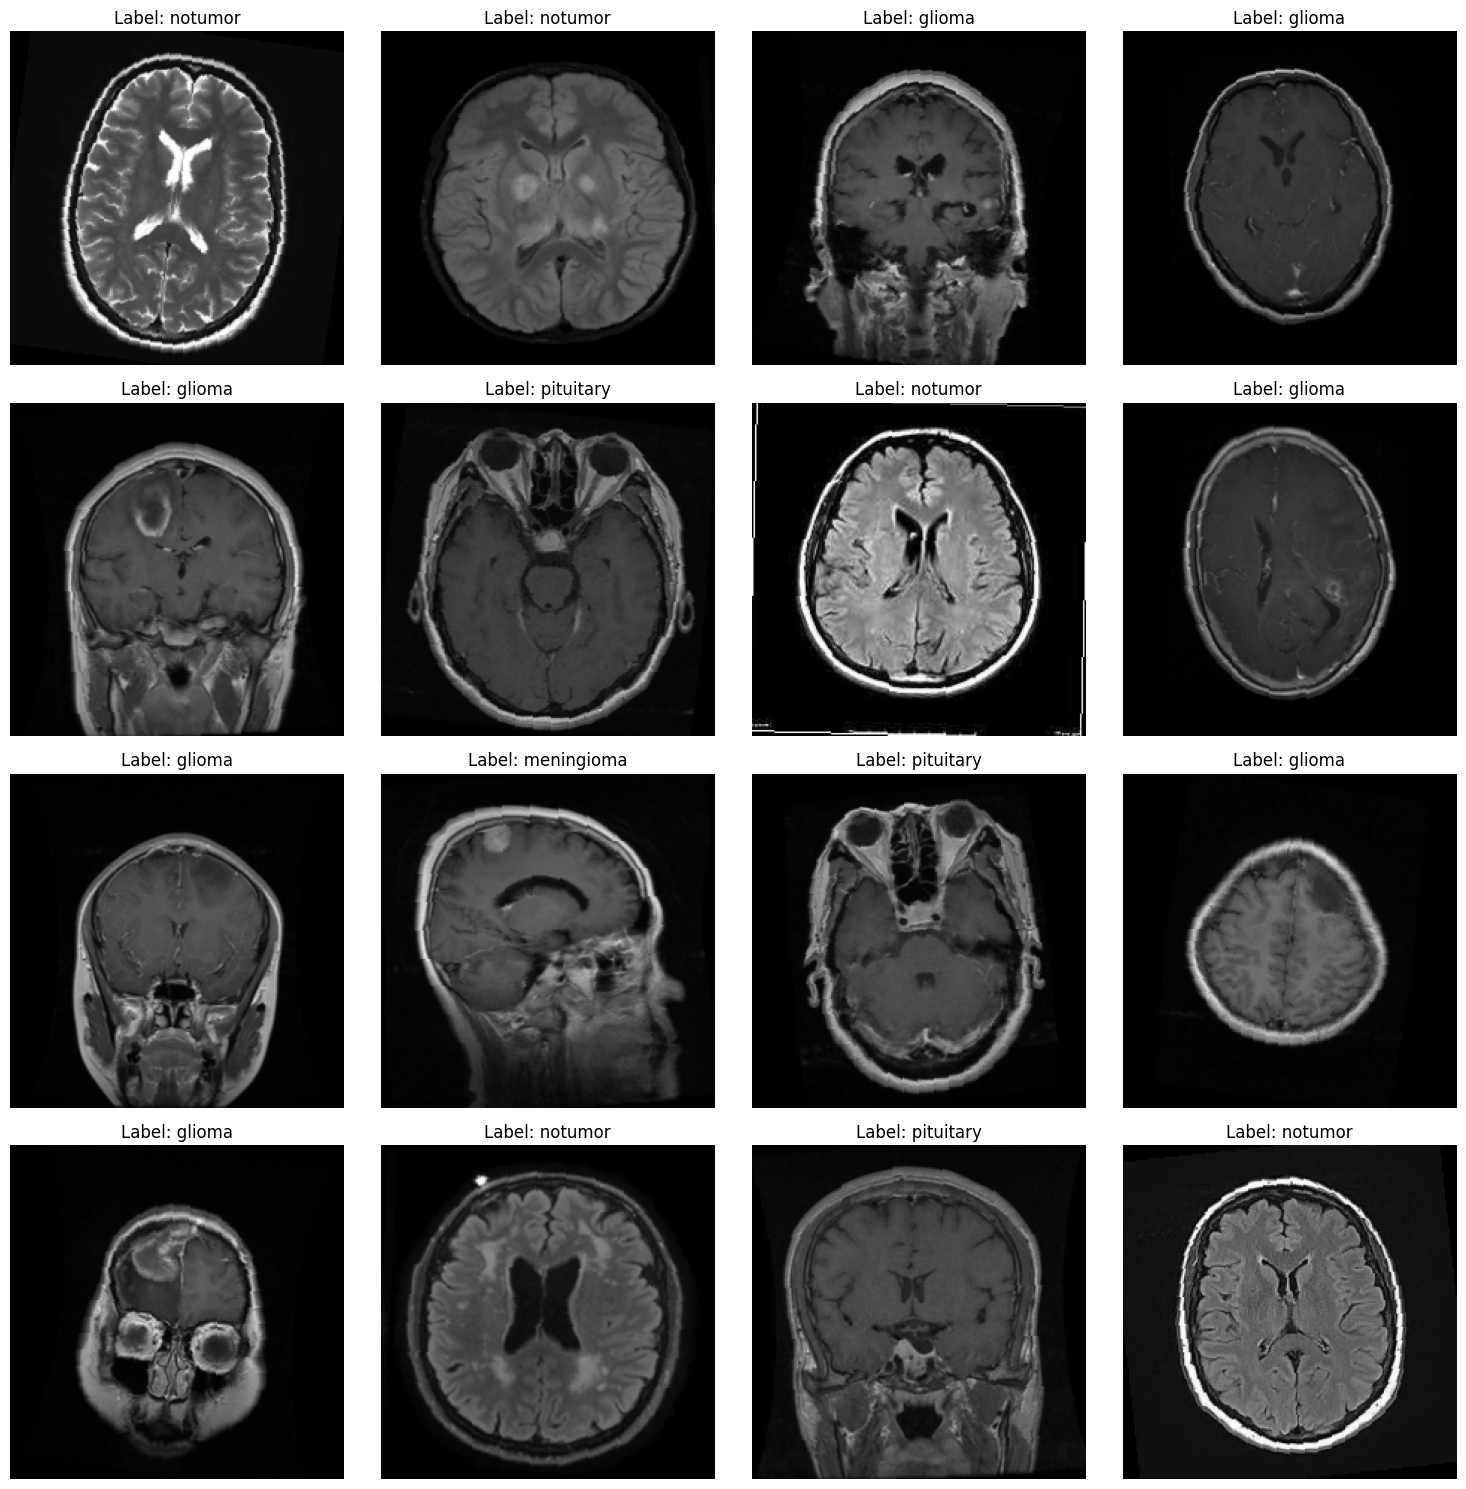

In [5]:
# Visualize a batch of images and labels 
data_iter = iter(train_loader)
images, labels = next(data_iter)

images = denormalize(images)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))

fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [6]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            # 3 x 16 x 16
            nn.Conv2d(3, 16, kernel_size=3, padding=1),    # 16 x 224 x 224
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # 16 x 112 x 112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),   # 32 x 112 x 112
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # 32 x 56 x 56
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),     # Faltten: 32 * 56 * 56 → 128
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)       # Match classes size
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  
        return x

model = TumorClassifier(num_classes=4)
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [8]:
# Training loop
num_epochs = 20
best_val_accuracy = 0.0
patience = 5
epochs_without_improvement = 0

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for the training loop
    train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update tqdm description
        train_pbar.set_postfix({'Loss': train_loss / (train_pbar.n + 1), 'Accuracy': correct / total})
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update tqdm description
            val_pbar.set_postfix({'Loss': val_loss / (val_pbar.n + 1), 'Accuracy': correct / total})
            
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')
    
    # Save the best model and check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping
    if epochs_without_improvement >= patience:
        torch.save(model.state_dict(), 'classifier.pth')
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

Epoch [1/20] Validation: 100%|██████████| 82/82 [00:09<00:00,  8.37it/s, Loss=0.508, Accuracy=0.815]


Epoch [1/20], Training Loss: 275.5051, Training Accuracy: 74.00%, Validation Loss: 41.6225, Validation Accuracy: 81.46%


Epoch [2/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.96it/s, Loss=0.322, Accuracy=0.879]


Epoch [2/20], Training Loss: 130.6070, Training Accuracy: 86.68%, Validation Loss: 26.0449, Validation Accuracy: 87.95%


Epoch [3/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.21it/s, Loss=0.236, Accuracy=0.915]


Epoch [3/20], Training Loss: 89.4327, Training Accuracy: 90.48%, Validation Loss: 19.1539, Validation Accuracy: 91.53%


Epoch [4/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.32it/s, Loss=0.166, Accuracy=0.932] 


Epoch [4/20], Training Loss: 67.0287, Training Accuracy: 92.96%, Validation Loss: 13.4745, Validation Accuracy: 93.21%


Epoch [5/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.07it/s, Loss=0.177, Accuracy=0.94] 


Epoch [5/20], Training Loss: 52.2488, Training Accuracy: 94.63%, Validation Loss: 14.3276, Validation Accuracy: 93.97%


Epoch [6/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.37it/s, Loss=0.152, Accuracy=0.95] 


Epoch [6/20], Training Loss: 38.3375, Training Accuracy: 96.24%, Validation Loss: 12.3028, Validation Accuracy: 95.04%


Epoch [7/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.50it/s, Loss=0.159, Accuracy=0.953]


Epoch [7/20], Training Loss: 31.4511, Training Accuracy: 97.36%, Validation Loss: 12.8678, Validation Accuracy: 95.35%


Epoch [8/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.00it/s, Loss=0.15, Accuracy=0.961] 


Epoch [8/20], Training Loss: 25.0627, Training Accuracy: 97.78%, Validation Loss: 12.1881, Validation Accuracy: 96.11%


Epoch [9/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.59it/s, Loss=0.141, Accuracy=0.96] 


Epoch [9/20], Training Loss: 20.5514, Training Accuracy: 97.97%, Validation Loss: 11.3988, Validation Accuracy: 95.96%


Epoch [10/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.34it/s, Loss=0.131, Accuracy=0.962] 


Epoch [10/20], Training Loss: 22.6882, Training Accuracy: 97.95%, Validation Loss: 10.6081, Validation Accuracy: 96.19%


Epoch [11/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.88it/s, Loss=0.093, Accuracy=0.973] 


Epoch [11/20], Training Loss: 17.7919, Training Accuracy: 98.44%, Validation Loss: 7.5370, Validation Accuracy: 97.33%


Epoch [12/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.82it/s, Loss=0.113, Accuracy=0.969] 


Epoch [12/20], Training Loss: 14.1594, Training Accuracy: 98.77%, Validation Loss: 9.1391, Validation Accuracy: 96.95%


Epoch [13/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.54it/s, Loss=0.103, Accuracy=0.973] 


Epoch [13/20], Training Loss: 11.6517, Training Accuracy: 99.00%, Validation Loss: 8.3809, Validation Accuracy: 97.33%


Epoch [14/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.44it/s, Loss=0.144, Accuracy=0.96]  


Epoch [14/20], Training Loss: 11.8911, Training Accuracy: 98.97%, Validation Loss: 11.6794, Validation Accuracy: 96.03%


Epoch [15/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.20it/s, Loss=0.181, Accuracy=0.958]


Epoch [15/20], Training Loss: 18.6752, Training Accuracy: 98.18%, Validation Loss: 14.6624, Validation Accuracy: 95.80%


Epoch [16/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.00it/s, Loss=0.0697, Accuracy=0.983]


Epoch [16/20], Training Loss: 9.7411, Training Accuracy: 99.21%, Validation Loss: 5.6491, Validation Accuracy: 98.32%


Epoch [17/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.17it/s, Loss=0.0834, Accuracy=0.982]


Epoch [17/20], Training Loss: 7.4283, Training Accuracy: 99.19%, Validation Loss: 6.7554, Validation Accuracy: 98.17%


Epoch [18/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.25it/s, Loss=0.108, Accuracy=0.978] 


Epoch [18/20], Training Loss: 9.9777, Training Accuracy: 99.18%, Validation Loss: 8.7462, Validation Accuracy: 97.79%


Epoch [19/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.76it/s, Loss=0.16, Accuracy=0.964] 


Epoch [19/20], Training Loss: 10.2193, Training Accuracy: 99.28%, Validation Loss: 12.9902, Validation Accuracy: 96.41%


Epoch [20/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.43it/s, Loss=0.277, Accuracy=0.963] 

Epoch [20/20], Training Loss: 9.9582, Training Accuracy: 99.05%, Validation Loss: 22.4266, Validation Accuracy: 96.26%


# Model Evaluation

In [10]:
# Load the best model
model.load_state_dict(torch.load('classifier.pth'))

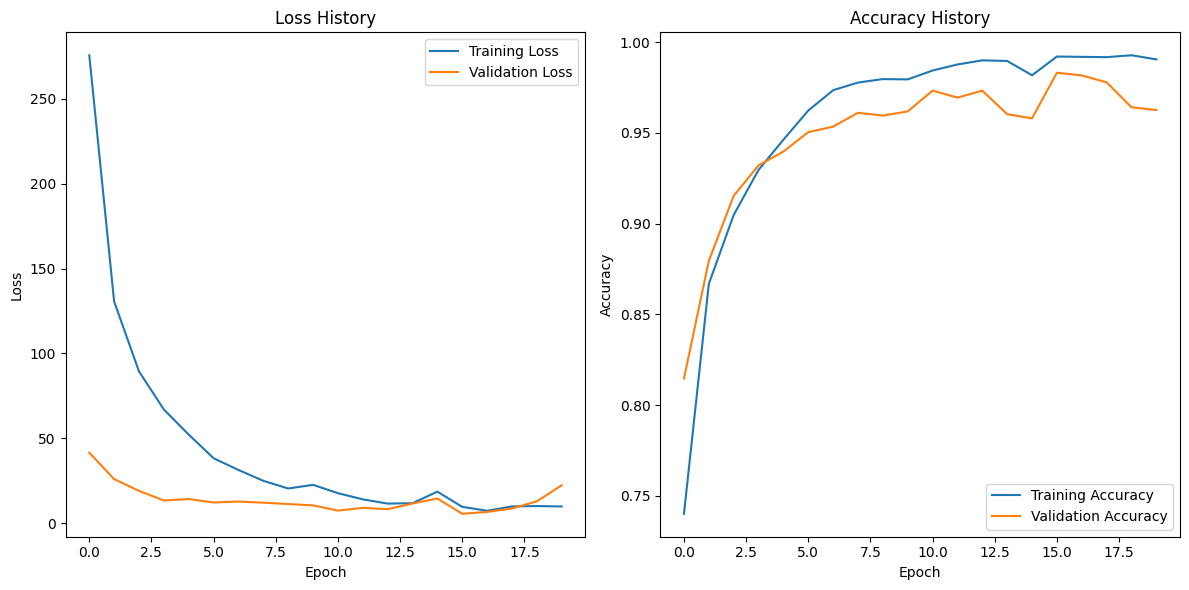

Validation Accuracy: 96.26%


In [11]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

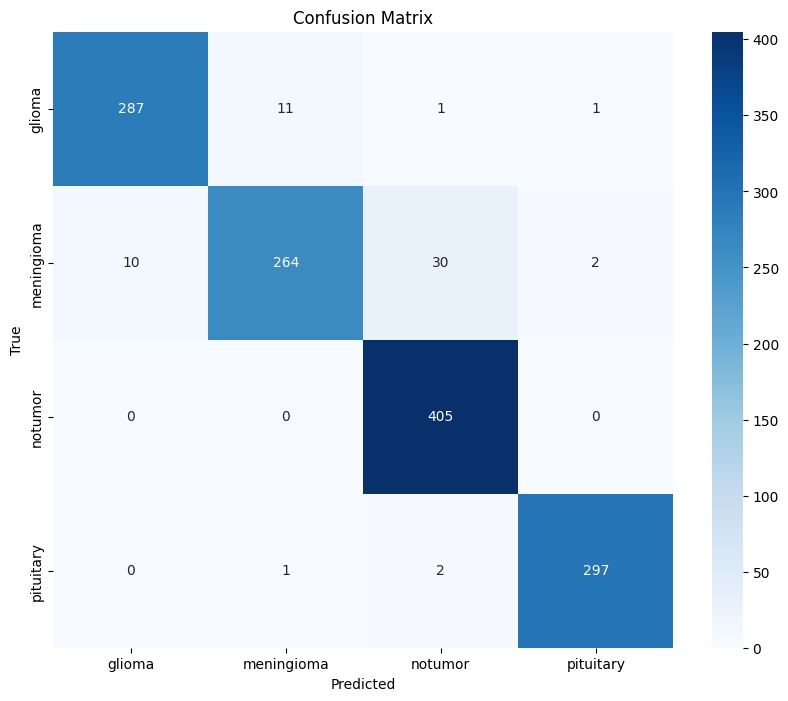

              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.96      0.86      0.91       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311

Accuracy: 95.5759%


In [12]:
model.eval()

all_labels = []
all_predictions = []

# Forward pass on validation dataset for creating report
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        
        val, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)

class_names = val_dataset.classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate and print classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Calculate and print overall accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy: {accuracy*100:.4f}%")